# Required Installations

In [ ]:
%%capture
!pip install gguf
import os, re
import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
!pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
!pip install --no-deps unsloth
!pip install transformers==4.55.4
!pip install -U packaging ninja
!pip install -U flash-attn --no-build-isolation
!pip install -q evaluate
!pip install -U wandb

# Data Preprocessing

In [ ]:
import pandas as pd
data = pd.read_csv('/content/mle_screening_dataset.csv')
data

,question,answer
0,What is (are) Glaucoma ?,Glaucoma is a group of diseases that can damag...
1,What is (are) Glaucoma ?,The optic nerve is a bundle of more than 1 mil...
2,What is (are) Glaucoma ?,Open-angle glaucoma is the most common form of...
3,Who is at risk for Glaucoma? ?,Anyone can develop glaucoma. Some people are a...
4,How to prevent Glaucoma ?,"At this time, we do not know how to prevent gl..."
...,...,...
16401,What is (are) Diabetic Neuropathies: The Nerve...,Autonomic neuropathy affects the nerves that c...
16402,What is (are) Diabetic Neuropathies: The Nerve...,"Proximal neuropathy, sometimes called lumbosac..."
16403,What is (are) Diabetic Neuropathies: The Nerve...,Focal neuropathy appears suddenly and affects ...
16404,How to prevent Diabetic Neuropathies: The Nerv...,The best way to prevent neuropathy is to keep ...


In [ ]:
data["answer"][0]

"Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.)  See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more.  See a glossary of glaucoma terms."

In [ ]:
data["answer"][1]

'The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.'

In [ ]:
data["answer"][2]

'Open-angle glaucoma is the most common form of glaucoma. In the normal eye, the clear fluid leaves the anterior chamber at the open angle where the cornea and iris meet. When the fluid reaches the angle, it flows through a spongy meshwork, like a drain, and leaves the eye. Sometimes, when the fluid reaches the angle, it passes too slowly through the meshwork drain, causing the pressure inside the eye to build. If the pressure damages the optic nerve, open-angle glaucoma -- and vision loss -- may result.'

In [ ]:
# group duplicate questions with multiple answers together in a tuple.
grouped = data.groupby("question")
grouped_ds = pd.DataFrame(columns=["question", "answers"])

questions = []
answers = []
for q, a in grouped:
    questions.append(q)
    answers.append(tuple(a["answer"]))

grouped_ds["question"] = questions
grouped_ds["answers"] = answers

grouped_ds

,question,answers
0,Do you have information about A1C,(Summary : A1C is a blood test for type 2 diab...
1,Do you have information about Acupuncture,(Summary : Acupuncture has been practiced in C...
2,Do you have information about Adoption,(Summary : Adoption brings a child born to oth...
3,Do you have information about Advance Directives,(Summary : What kind of medical care would you...
4,Do you have information about African American...,(Summary : Every racial or ethnic group has sp...
...,...,...
14976,what research (or clinical trials) is being do...,(New types of treatment are being tested in cl...
14977,what research (or clinical trials) is being do...,(The National Institute of Neurological Disord...
14978,what research (or clinical trials) is being do...,(The National Institute of Neurological Disord...
14979,what research is being done for Tuberculosis (...,(TB Epidemiologic Studies Consortium\n \n The...


In [ ]:
grouped_ds["multi-answers"] = grouped_ds["answers"].map(lambda x: len(x) > 1)
grouped_ds

,question,answers,multi-answers
0,Do you have information about A1C,(Summary : A1C is a blood test for type 2 diab...,False
1,Do you have information about Acupuncture,(Summary : Acupuncture has been practiced in C...,False
2,Do you have information about Adoption,(Summary : Adoption brings a child born to oth...,False
3,Do you have information about Advance Directives,(Summary : What kind of medical care would you...,False
4,Do you have information about African American...,(Summary : Every racial or ethnic group has sp...,False
...,...,...,...
14976,what research (or clinical trials) is being do...,(New types of treatment are being tested in cl...,False
14977,what research (or clinical trials) is being do...,(The National Institute of Neurological Disord...,False
14978,what research (or clinical trials) is being do...,(The National Institute of Neurological Disord...,False
14979,what research is being done for Tuberculosis (...,(TB Epidemiologic Studies Consortium\n \n The...,False


<Axes: ylabel='multi-answers'>

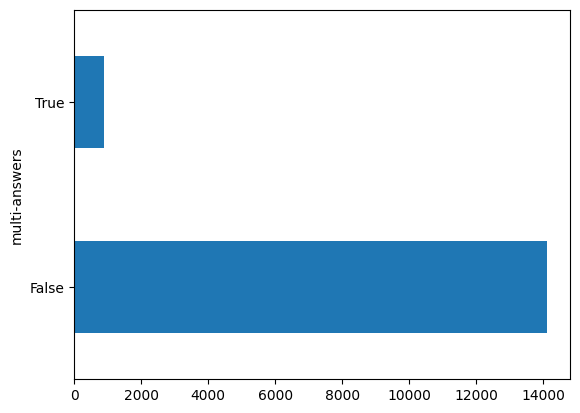

In [ ]:
from matplotlib import pyplot as plt
grouped_ds.groupby('multi-answers').size().plot(kind='barh')

In [ ]:
# I need to pick the best answer for the duplicated questions
# I need to drop the questions with nonsense answers

dups = grouped_ds.loc[grouped_ds["multi-answers"] == True]
dups

,question,answers,multi-answers
1431,How to diagnose Adrenal Insufficiency and Addi...,"(In its early stages, adrenal insufficiency ca...",True
1444,How to diagnose Alzheimer's Caregiving ?,(Now that your family member or friend has rec...,True
1445,How to diagnose Alzheimer's Disease ?,(The only definitive way to diagnose Alzheimer...,True
1448,How to diagnose Amyloidosis and Kidney Disease ?,(A health care provider diagnoses primary amyl...,True
1488,How to diagnose Breast Cancer ?,"(Most cancers in their early, most treatable s...",True
...,...,...,...
14901,what research (or clinical trials) is being do...,(The National Institute on Deafness and Other ...,True
14905,what research (or clinical trials) is being do...,(Scientists continue to look at new ways to pr...,True
14907,what research (or clinical trials) is being do...,(Scientists who are working to better understa...,True
14927,what research (or clinical trials) is being do...,(Many Areas of Research Scientists are constan...,True


In [ ]:
# create a column with question and answers grouped together to create input format
inputs = []
for row in zip(*dups.to_dict("list").values()):
    entry = {
        "question": row[0],
        "choices": row[1]
    }
    inputs.append(entry)
dups["inputs"] = inputs
dups

/tmp/ipython-input-3256613378.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups["inputs"] = inputs


,question,answers,multi-answers,inputs
1431,How to diagnose Adrenal Insufficiency and Addi...,"(In its early stages, adrenal insufficiency ca...",True,{'question': 'How to diagnose Adrenal Insuffic...
1444,How to diagnose Alzheimer's Caregiving ?,(Now that your family member or friend has rec...,True,{'question': 'How to diagnose Alzheimer's Care...
1445,How to diagnose Alzheimer's Disease ?,(The only definitive way to diagnose Alzheimer...,True,{'question': 'How to diagnose Alzheimer's Dise...
1448,How to diagnose Amyloidosis and Kidney Disease ?,(A health care provider diagnoses primary amyl...,True,{'question': 'How to diagnose Amyloidosis and ...
1488,How to diagnose Breast Cancer ?,"(Most cancers in their early, most treatable s...",True,{'question': 'How to diagnose Breast Cancer ?'...
...,...,...,...,...
14901,what research (or clinical trials) is being do...,(The National Institute on Deafness and Other ...,True,{'question': 'what research (or clinical trial...
14905,what research (or clinical trials) is being do...,(Scientists continue to look at new ways to pr...,True,{'question': 'what research (or clinical trial...
14907,what research (or clinical trials) is being do...,(Scientists who are working to better understa...,True,{'question': 'what research (or clinical trial...
14927,what research (or clinical trials) is being do...,(Many Areas of Research Scientists are constan...,True,{'question': 'what research (or clinical trial...


In [ ]:
dups.loc[dups["question"] == "What is (are) Glaucoma ?"]["answers"].tolist()

[("Glaucoma is a group of diseases that can damage the eye's optic nerve and result in vision loss and blindness. The most common form of the disease is open-angle glaucoma. With early treatment, you can often protect your eyes against serious vision loss. (Watch the video to learn more about glaucoma. To enlarge the video, click the brackets in the lower right-hand corner. To reduce the video, press the Escape (Esc) button on your keyboard.)  See this graphic for a quick overview of glaucoma, including how many people it affects, whos at risk, what to do if you have it, and how to learn more.  See a glossary of glaucoma terms.",
  'The optic nerve is a bundle of more than 1 million nerve fibers. It connects the retina to the brain.',
  'Open-angle glaucoma is the most common form of glaucoma. In the normal eye, the clear fluid leaves the anterior chamber at the open angle where the cornea and iris meet. When the fluid reaches the angle, it flows through a spongy meshwork, like a drain

In [ ]:
# system prompt for deduplication
dedup_system_prompt = """You are a highly intelligent assistant who reviews a medical related question answer dataset scraped \
from the web. Your job is to review the following answers for the provided question and determine which \
answer is the best one according to these criteria:\n\n1: It answers the immediate question succinctly, but completely without leaving out important detail. \
prioritize answer completeness over conciseness.\n2: It does not provide irrelevant information, does not give links or unverified contact information \
such as email or phone numbers, and focuses on answering the question at hand\n\nOutput instructions: you will only output a single integer as your output which will \
denote which answer option is the best one. The indexing should begin at 1. \n\nNote: if none of the answers provided are satisfactory, use the special index 0 as your output."""

print(dedup_system_prompt)

def format_dedup_input(inp):
    p = f"<|QUESTION|>{inp["question"]}<|QUESTION|>"
    for i, ans in enumerate(inp["choices"]):
        p += f"\n\n<|OPTION {i+1}|>{ans}<|OPTION {i+1}|>"
    return p

print(format_dedup_input(inputs[0]))

You are a highly intelligent assistant who reviews a medical related question answer dataset scraped from the web. Your job is to review the following answers for the provided question and determine which answer is the best one according to these criteria:

1: It answers the immediate question succinctly, but completely without leaving out important detail. prioritize answer completeness over conciseness.
2: It does not provide irrelevant information, does not give links or unverified contact information such as email or phone numbers, and focuses on answering the question at hand

Output instructions: you will only output a single integer as your output which will denote which answer option is the best one. The indexing should begin at 1. 

Note: if none of the answers provided are satisfactory, use the special index 0 as your output.
<|QUESTION|>How to diagnose Adrenal Insufficiency and Addison's Disease ?<|QUESTION|>

<|OPTION 1|>In its early stages, adrenal insufficiency can be dif

In [ ]:
dups["prompts"] = dups["inputs"].apply(lambda x: format_dedup_input(x))
dups

/tmp/ipython-input-2861849638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dups["prompts"] = dups["inputs"].apply(lambda x: format_dedup_input(x))


,question,answers,multi-answers,inputs,prompts
1431,How to diagnose Adrenal Insufficiency and Addi...,"(In its early stages, adrenal insufficiency ca...",True,{'question': 'How to diagnose Adrenal Insuffic...,<|QUESTION|>How to diagnose Adrenal Insufficie...
1444,How to diagnose Alzheimer's Caregiving ?,(Now that your family member or friend has rec...,True,{'question': 'How to diagnose Alzheimer's Care...,<|QUESTION|>How to diagnose Alzheimer's Caregi...
1445,How to diagnose Alzheimer's Disease ?,(The only definitive way to diagnose Alzheimer...,True,{'question': 'How to diagnose Alzheimer's Dise...,<|QUESTION|>How to diagnose Alzheimer's Diseas...
1448,How to diagnose Amyloidosis and Kidney Disease ?,(A health care provider diagnoses primary amyl...,True,{'question': 'How to diagnose Amyloidosis and ...,<|QUESTION|>How to diagnose Amyloidosis and Ki...
1488,How to diagnose Breast Cancer ?,"(Most cancers in their early, most treatable s...",True,{'question': 'How to diagnose Breast Cancer ?'...,<|QUESTION|>How to diagnose Breast Cancer ?<|Q...
...,...,...,...,...,...
14901,what research (or clinical trials) is being do...,(The National Institute on Deafness and Other ...,True,{'question': 'what research (or clinical trial...,<|QUESTION|>what research (or clinical trials)...
14905,what research (or clinical trials) is being do...,(Scientists continue to look at new ways to pr...,True,{'question': 'what research (or clinical trial...,<|QUESTION|>what research (or clinical trials)...
14907,what research (or clinical trials) is being do...,(Scientists who are working to better understa...,True,{'question': 'what research (or clinical trial...,<|QUESTION|>what research (or clinical trials)...
14927,what research (or clinical trials) is being do...,(Many Areas of Research Scientists are constan...,True,{'question': 'what research (or clinical trial...,<|QUESTION|>what research (or clinical trials)...


In [ ]:
from unsloth import FastModel
import torch

# load Unsloth model
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Instruct-2507",
    max_seq_length = 16384,
    load_in_4bit = False,
    load_in_8bit = True,
    full_finetuning = False,
    device_map="auto",
    attn_implementation="flash_attention_2"
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.10: Fast Qwen3 patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.08G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
# prepare the model input
def apply_template(system_prompt, user_prompt):
    message = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    return tokenizer.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=True,
    )

dups["prompts"] = dups["prompts"].apply(lambda x: apply_template(dedup_system_prompt, x))
dups

,Unnamed: 0.1,Unnamed: 0,question,answers,multi-answers,inputs,prompts,outputs,final
0,0,0,How to diagnose Adrenal Insufficiency and Addi...,"('In its early stages, adrenal insufficiency c...",True,"{'question': ""How to diagnose Adrenal Insuffic...",<|im_start|>system\nYou are a highly intellige...,1,"In its early stages, adrenal insufficiency can..."
1,2,2,How to diagnose Alzheimer's Disease ?,('The only definitive way to diagnose Alzheime...,True,"{'question': ""How to diagnose Alzheimer's Dise...",<|im_start|>system\nYou are a highly intellige...,1,The only definitive way to diagnose Alzheimer'...
2,3,3,How to diagnose Amyloidosis and Kidney Disease ?,('A health care provider diagnoses primary amy...,True,{'question': 'How to diagnose Amyloidosis and ...,<|im_start|>system\nYou are a highly intellige...,1,A health care provider diagnoses primary amylo...
3,4,4,How to diagnose Breast Cancer ?,"(""Most cancers in their early, most treatable ...",True,{'question': 'How to diagnose Breast Cancer ?'...,<|im_start|>system\nYou are a highly intellige...,3,Tests that examine the breasts are used to det...
4,5,5,How to diagnose COPD ?,"('To confirm a COPD diagnosis, a doctor will u...",True,"{'question': 'How to diagnose COPD ?', 'choice...",<|im_start|>system\nYou are a highly intellige...,1,"To confirm a COPD diagnosis, a doctor will use..."
...,...,...,...,...,...,...,...,...,...
852,884,884,what research (or clinical trials) is being do...,('The National Institute on Deafness and Other...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1,The National Institute on Deafness and Other C...
853,885,885,what research (or clinical trials) is being do...,"(""Scientists continue to look at new ways to p...",True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1,Scientists continue to look at new ways to pre...
854,886,886,what research (or clinical trials) is being do...,('Scientists who are working to better underst...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1,Scientists who are working to better understan...
855,887,887,what research (or clinical trials) is being do...,('Many Areas of Research Scientists are consta...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1,Many Areas of Research Scientists are constant...


In [ ]:
dups.to_csv("dups.csv", index=False)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import torch
import pandas as pd

dups = pd.read_csv("dups.csv")

# Create text dataset
class TextDataset(Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        return text

dataset = TextDataset(dups["prompts"].tolist())
dataloader = DataLoader(dataset, batch_size=2, shuffle=False)

# Turns out the overhead of tokenization was negligible, but I clean it up later.
out = []
for batch_text in tqdm(dataloader):
    model_inputs = tokenizer.batch_encode_plus(
        batch_text,
        padding="longest",
        padding_side="left",
        truncation=True,
        return_tensors="pt",
    ).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **model_inputs,
            temperature=0.8,
            top_p=0.8,
            top_k=20,
            max_new_tokens=10
        )
    decoded = tokenizer.batch_decode(
        outputs,
        skip_special_tokens=True
    )
    out.extend(decoded)

In [ ]:
responses = []
for o in out:
    res = o.split("assistant\n")[1]
    responses.append(res)
dups["outputs"] = responses

In [ ]:
dups.to_csv("dups_with_outputs.csv", index=False)

In [ ]:
dups = dups.loc[dups["outputs"] != 0]
dups

,Unnamed: 0,question,answers,multi-answers,inputs,prompts,outputs
0,0,How to diagnose Adrenal Insufficiency and Addi...,"('In its early stages, adrenal insufficiency c...",True,"{'question': ""How to diagnose Adrenal Insuffic...",<|im_start|>system\nYou are a highly intellige...,1
2,2,How to diagnose Alzheimer's Disease ?,('The only definitive way to diagnose Alzheime...,True,"{'question': ""How to diagnose Alzheimer's Dise...",<|im_start|>system\nYou are a highly intellige...,1
3,3,How to diagnose Amyloidosis and Kidney Disease ?,('A health care provider diagnoses primary amy...,True,{'question': 'How to diagnose Amyloidosis and ...,<|im_start|>system\nYou are a highly intellige...,1
4,4,How to diagnose Breast Cancer ?,"(""Most cancers in their early, most treatable ...",True,{'question': 'How to diagnose Breast Cancer ?'...,<|im_start|>system\nYou are a highly intellige...,3
5,5,How to diagnose COPD ?,"('To confirm a COPD diagnosis, a doctor will u...",True,"{'question': 'How to diagnose COPD ?', 'choice...",<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...,...,...,...
884,884,what research (or clinical trials) is being do...,('The National Institute on Deafness and Other...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1
885,885,what research (or clinical trials) is being do...,"(""Scientists continue to look at new ways to p...",True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1
886,886,what research (or clinical trials) is being do...,('Scientists who are working to better underst...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1
887,887,what research (or clinical trials) is being do...,('Many Areas of Research Scientists are consta...,True,{'question': 'what research (or clinical trial...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
import ast

# 0 index is reserved for rejection samples
# subtract outputs by 1 in order to select the correct answer index
final = []
for _, row in dups.iterrows():
    selected = ast.literal_eval(row["answers"])[int(row["outputs"])-1]
    final.append(selected)
dups["final"] = final
dups


In [ ]:
# inspecting outputs
for i, row in dups.head().iterrows():
    print(f"QUESTION: {row["question"]}")
    print(f"ANSWER: {row["final"]}")
    print()

QUESTION: How to diagnose Adrenal Insufficiency and Addison's Disease ?
ANSWER: In its early stages, adrenal insufficiency can be difficult to diagnose. A health care provider may suspect it after reviewing a persons medical history and symptoms.
                
A diagnosis of adrenal insufficiency is confirmed through hormonal blood and urine tests. A health care provider uses these tests first to determine whether cortisol levels are too low and then to establish the cause. Imaging studies of the adrenal and pituitary glands can be useful in helping to establish the cause.
                
A lab technician performs the following tests in a health care providers office, a commercial facility, or a hospital.
                
Hormonal Blood and Urine Tests
                
- ACTH stimulation test. The ACTH stimulation test is the most commonly used test for diagnosing adrenal insufficiency. In this test, the patient is given an intravenous (IV) injection of synthetic ACTH, and samples 

In [ ]:
dups.to_csv("dups_processed.csv", index=False)

In [ ]:
# inspecting rejected answers
dups = pd.read_csv("dups_with_outputs.csv")
dropped = dups.loc[dups["outputs"] == 0]
for i, row in dropped.head().iterrows():
    print(f"QUESTION: {row["question"]}")
    print(f"ANSWER: {row["answers"]}")
    print()

QUESTION: How to diagnose Alzheimer's Caregiving ?
ANSWER: ('Now that your family member or friend has received a diagnosis of Alzheimers disease, its important to learn as much as you can about the disease and how to care for someone who has it. You may also want to know the right way to share the news with family and friends. Learning About Alzheimers Sometimes, you may feel that you don\'t know how to care for the person with Alzheimers. This is a common feeling among caregivers of people with Alzheimers because each day may bring different challenges. Learning about the disease can help you understand and cope with these challenges. Here is some information about Alzheimers and ways you can learn more about it. Alzheimers disease is an illness of the brain. It causes large numbers of nerve cells in the brain to die. This affects a persons ability to remember things and think clearly. People with Alzheimers become forgetful and easily confused and may have a hard time concentrating.

In [ ]:
dups = pd.read_csv("dups_processed.csv")
# create clean dataset to prepare for merge
processed = pd.DataFrame(columns=["question", "answers"])
processed["question"] = dups["question"]
processed["answers"] = dups["final"]
processed

,question,answers
0,How to diagnose Adrenal Insufficiency and Addi...,"In its early stages, adrenal insufficiency can..."
1,How to diagnose Alzheimer's Disease ?,The only definitive way to diagnose Alzheimer'...
2,How to diagnose Amyloidosis and Kidney Disease ?,A health care provider diagnoses primary amylo...
3,How to diagnose Breast Cancer ?,Tests that examine the breasts are used to det...
4,How to diagnose COPD ?,"To confirm a COPD diagnosis, a doctor will use..."
...,...,...
852,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...
853,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...
854,what research (or clinical trials) is being do...,Scientists who are working to better understan...
855,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...


In [ ]:
grouped_ds["answers"] = grouped_ds["answers"].apply(lambda x: x[0])
grouped_ds


,question,answers,multi-answers
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,False
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,False
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,False
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,False
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,False
...,...,...,...
14976,what research (or clinical trials) is being do...,New types of treatment are being tested in cli...,False
14977,what research (or clinical trials) is being do...,The National Institute of Neurological Disorde...,False
14978,what research (or clinical trials) is being do...,The National Institute of Neurological Disorde...,False
14979,what research is being done for Tuberculosis (...,TB Epidemiologic Studies Consortium\n \n The ...,False


In [ ]:
# concatenate original grouped dataset with deduplicated dataset
processed = pd.concat([grouped_ds, processed])
processed

,question,answers,multi-answers
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,False
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,False
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,False
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,False
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,False
...,...,...,...
852,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,NaN
853,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,NaN
854,what research (or clinical trials) is being do...,Scientists who are working to better understan...,NaN
855,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,NaN


In [ ]:
processed.drop(columns=["multi-answers"], inplace=True)
# keep the last for duplicates because I just deduplicated that and selected the best answer
processed.drop_duplicates(subset=["question"], keep="last", inplace=True)
processed

,question,answers
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...
...,...,...
852,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...
853,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...
854,what research (or clinical trials) is being do...,Scientists who are working to better understan...
855,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...


# Data Preprocessing Step 2: quality check

In [ ]:
# step 2: checking answer quality
qa_system_prompt = """You are a highly intelligent assistant who reviews a medical related question answer dataset scraped \
from the web. Your job is to review the following answer for the provided question and determine if the answer \
properly answers the question.\n\nOutput instructions: you will only output a boolean value of 1 or 0, with 1 indicating \
to keep the sample, or 0 denoting to exclude it. The criteria for exclusion is simply based on whether the answer properly \
answers the question. If the answer is nonsensical or irrelevant, be sure to exclude it. Do not judge the answer based on \
correctness because you do not have medical knowledge. A valid answer includes those that admits there is currently no \
answer available to the question (for example, if a disease or condition has no cure or treatment available.)""" # last sentence added in v2

def format_qa_input(inp):
    return f"<|QUESTION|>{inp['question']}<|QUESTION|>\n\n<|ANSWER|>{inp['answers']}<|ANSWER|>"

processed["prompts"] = processed.apply(lambda x: format_qa_input(x), axis=1)
processed

,question,answers,prompts
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|QUESTION|>Do you have information about A1C<...
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|QUESTION|>Do you have information about Acup...
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|QUESTION|>Do you have information about Adop...
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|QUESTION|>Do you have information about Adva...
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|QUESTION|>Do you have information about Afri...
...,...,...,...
852,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|QUESTION|>what research (or clinical trials)...
853,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|QUESTION|>what research (or clinical trials)...
854,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|QUESTION|>what research (or clinical trials)...
855,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|QUESTION|>what research (or clinical trials)...


In [ ]:
# apply chat template
processed["prompts"] = processed["prompts"].apply(lambda x: apply_template(qa_system_prompt, x))
processed

NameError: name 'apply_template' is not defined

In [ ]:
processed.drop(columns=["index"], inplace=True)
processed

,question,answers,prompts
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...
...,...,...,...
14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...
14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...
14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...
14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...


In [ ]:
processed.to_csv("qa_inputs_v2.csv", index=False)

In [ ]:
import pandas as pd

processed = pd.read_csv("qa_inputs_v2.csv")
dataset = TextDataset(processed["prompts"].tolist())
dataloader = DataLoader(dataset, batch_size=8, shuffle=False)

def generate(dataloader, tokenizer, model):
    for batch_text in tqdm(dataloader):
        model_inputs = tokenizer.batch_encode_plus(
            batch_text,
            padding="longest",
            padding_side="left",
            truncation=True,
            return_tensors="pt",
        ).to(model.device)
        with torch.no_grad():
            yield model.generate(
                **model_inputs,
                temperature=0.8,
                top_p=0.8,
                top_k=20,
                max_new_tokens=10
            )

out = []
for batch in generate(dataloader, tokenizer, model):
    decoded = tokenizer.batch_decode(
        batch,
        skip_special_tokens=True
    )
    out.extend(decoded)


In [ ]:
# split the text at the asssistant response line and get the response.
# 1 = keep, 0 = reject.
def postprocess(outputs):
    responses = []
    for o in outputs:
        res = o.split("assistant\n")[1]
        responses.append(res)
    return responses

processed["outputs"] = postprocess(out)
processed

,Unnamed: 0,question,answers,prompts,outputs
0,0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...,...
14976,14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
# there are 1502 rejected samples
processed = pd.read_csv("/content/qa_outputs_v2.csv")
rejected = processed.loc[processed["outputs"] != "1"]
rejected

,Unnamed: 0.1,Unnamed: 0,question,answers,prompts,outputs
0,0,0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,1,1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,2,2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,3,3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,4,4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...,...,...
14976,14976,14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,14977,14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,14978,14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,14979,14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
# inspection of rejected samples
for i, row in rejected.head().iterrows():
    print(f"QUESTION: {row['question']}")
    print(f"ANSWER: {row['answers']}")
    print()

QUESTION: Do you have information about A1C
ANSWER: Summary : A1C is a blood test for type 2 diabetes and prediabetes. It measures your average blood glucose, or blood sugar, level over the past 3 months. Doctors may use the A1C alone or in combination with other diabetes tests to make a diagnosis. They also use the A1C to see how well you are managing your diabetes. This test is different from the blood sugar checks that people with diabetes do every day.    Your A1C test result is given in percentages. The higher the percentage, the higher your blood sugar levels have been:       - A normal A1C level is below 5.7 percent    - Prediabetes is between 5.7 to 6.4 percent. Having prediabetes is a risk factor for getting type 2 diabetes. People with prediabetes may need retests every year.    - Type 2 diabetes is above 6.5 percent    - If you have diabetes, you should have the A1C test at least twice a year. The A1C goal for many people with diabetes is below 7. It may be different for you

In [ ]:
processed.to_csv("qa_outputs_v2.csv")

# Merge and Process Dataset

In [ ]:
# download MedQuAD dataset
from datasets import load_dataset

dataset = load_dataset("lavita/MedQuAD")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-e36383d177026d(…):   0%|          | 0.00/10.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/47441 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['document_id', 'document_source', 'document_url', 'category', 'umls_cui', 'umls_semantic_types', 'umls_semantic_group', 'synonyms', 'question_id', 'question_focus', 'question_type', 'question', 'answer'],
        num_rows: 47441
    })
})

In [ ]:
# create a new dataframe with only desired fields
data = pd.DataFrame(columns=["question_focus", "question_type", "question", "answers"])
data["question_focus"] = dataset["train"]["question_focus"]
data["question_type"] = dataset["train"]["question_type"]
data["question"] = dataset["train"]["question"]
data["answers"] = dataset["train"]["answer"]
data

,question_focus,question_type,question,answers
0,keratoderma with woolly hair,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...
1,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...
2,keratoderma with woolly hair,genetic changes,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."
3,keratoderma with woolly hair,inheritance,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...
4,keratoderma with woolly hair,treatment,What are the treatments for keratoderma with w...,These resources address the diagnosis or manag...
...,...,...,...,...
47436,Hydrocodone,side effects,What are the side effects or risks of Hydrocod...,None
47437,Hydrocodone,storage and disposal,What should I know about storage and disposal ...,None
47438,Hydrocodone,emergency or overdose,What to do in case of emergency or overdose of...,None
47439,Hydrocodone,other information,What other information should I know about Hyd...,None


In [ ]:
# drop all rows with "None" as the answer
data["answers"] = data["answers"].apply(lambda x: str(x))
data = data.loc[data["answers"] != "None"]
data

,question_focus,question_type,question,answers
0,keratoderma with woolly hair,information,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...
1,keratoderma with woolly hair,frequency,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...
2,keratoderma with woolly hair,genetic changes,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."
3,keratoderma with woolly hair,inheritance,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...
4,keratoderma with woolly hair,treatment,What are the treatments for keratoderma with w...,These resources address the diagnosis or manag...
...,...,...,...,...
34547,What I need to know about Cirrhosis,treatment,What are the treatments for What I need to kno...,"Once you have cirrhosis, nothing can make all ..."
34548,What I need to know about Cirrhosis,treatment,What are the treatments for What I need to kno...,"If too much scar tissue forms, your liver coul..."
34549,What I need to know about Cirrhosis,prevention,How to prevent What I need to know about Cirrh...,"To prevent cirrhosis,\n \n- see..."
34550,What I need to know about Cirrhosis,considerations,What to do for What I need to know about Cirrh...,- Cirrhosis is scarring of the liver. Scar tis...


In [ ]:
qa_processed = pd.read_csv("qa_outputs_v2.csv")
qa_processed

,Unnamed: 0.1,Unnamed: 0,question,answers,prompts,outputs
0,0,0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,1,1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,2,2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,3,3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,4,4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...,...,...
14976,14976,14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,14977,14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,14978,14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,14979,14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
qa_processed.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)
qa_processed

,question,answers,prompts,outputs
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...
14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
# select only the rows that passed the vibe check
qa_processed["outputs"] = qa_processed["outputs"].apply(lambda x: int(x))
qa_processed = qa_processed.loc[qa_processed["outputs"] == 1]
qa_processed

,question,answers,prompts,outputs
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...
14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
# drop NaN rows
qa_processed.dropna(inplace=True)
qa_processed

/tmp/ipython-input-2089436392.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qa_processed.dropna(inplace=True)


,question,answers,prompts,outputs
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1
...,...,...,...,...
14976,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1
14977,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1
14978,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1
14979,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1


In [ ]:
keys = ["question", "answers"]

# semi-join: keep only original rows whose (q,a) appear in processed
matched = data.merge(qa_processed, on=keys, how="inner")
matched = matched[["question", "answers", "question_type", "question_focus"]]
matched

,question,answers,question_type,question_focus
0,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...,information,keratoderma with woolly hair
1,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...,frequency,keratoderma with woolly hair
2,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen...",genetic changes,keratoderma with woolly hair
3,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...,inheritance,keratoderma with woolly hair
4,What is (are) Knobloch syndrome ?,Knobloch syndrome is a rare condition characte...,information,Knobloch syndrome
...,...,...,...,...
13495,What are the symptoms of What I need to know a...,You may have no symptoms in the early stages o...,symptoms,What I need to know about Cirrhosis
13496,How to diagnose What I need to know about Cirr...,Your doctor will examine you and may perform\n...,exams and tests,What I need to know about Cirrhosis
13497,What are the treatments for What I need to kno...,"Once you have cirrhosis, nothing can make all ...",treatment,What I need to know about Cirrhosis
13498,How to prevent What I need to know about Cirrh...,"To prevent cirrhosis,\n \n- see...",prevention,What I need to know about Cirrhosis


In [ ]:
matched[keys].drop_duplicates(keep="last")

,question,answers
0,What is (are) keratoderma with woolly hair ?,Keratoderma with woolly hair is a group of rel...
1,How many people are affected by keratoderma wi...,Keratoderma with woolly hair is rare; its prev...
2,What are the genetic changes related to kerato...,"Mutations in the JUP, DSP, DSC2, and KANK2 gen..."
3,Is keratoderma with woolly hair inherited ?,Most cases of keratoderma with woolly hair hav...
4,What is (are) Knobloch syndrome ?,Knobloch syndrome is a rare condition characte...
...,...,...
13495,What are the symptoms of What I need to know a...,You may have no symptoms in the early stages o...
13496,How to diagnose What I need to know about Cirr...,Your doctor will examine you and may perform\n...
13497,What are the treatments for What I need to kno...,"Once you have cirrhosis, nothing can make all ..."
13498,How to prevent What I need to know about Cirrh...,"To prevent cirrhosis,\n \n- see..."


In [ ]:
keys = ["question", "answers"] # columns I care about

# inspect how many duplicate pairs exist in each (original and processed)
print("processed unique pairs:", qa_processed[keys].drop_duplicates().shape[0])
print("original  unique pairs:", data[keys].drop_duplicates().shape[0])

# which (q,a) are duplicated in the original
dupes_in_original = (
    data[keys].value_counts().reset_index(name="count").query("count > 1")
)
print("duplicate pairs in original:", len(dupes_in_original))
dupes_in_original.head()


processed unique pairs: 13476
original  unique pairs: 16359
duplicate pairs in original: 32


,question,answers,count
0,What causes Causes of Diabetes ?,Other types of diabetes have a variety of poss...,8
1,What to do for Causes of Diabetes ?,- Diabetes is a complex group of diseases with...,4
2,What causes Causes of Diabetes ?,Insulin Resistance and Beta Cell Dysfunction\n...,4
3,What causes Causes of Diabetes ?,Type 1 diabetes is caused by a lack of insulin...,4
4,What causes Causes of Diabetes ?,Type 2 diabetesthe most common form of diabete...,4


In [ ]:
# find pairs in processed dataset not found in original
missing = (
    qa_processed[keys].drop_duplicates()
    .merge(data[keys].drop_duplicates(), on=keys, how="left", indicator=True)
)
not_found = missing[missing["_merge"] == "left_only"][keys]
print("processed pairs not found in original:", len(not_found))
not_found.head()


processed pairs not found in original: 2


,question,answers
1973,How to prevent Eastern Equine Encephalitis ?,There is no vaccine against Eastern equine enc...
1999,How to prevent La Crosse Encephalitis ?,There is no vaccine against La Crosse encephal...


In [ ]:
# take original dataset, then merge only on items that are coinciding with the final processed dataset
orig_meta = (
    data
    .drop_duplicates(subset=keys, keep="first")
    [[*keys, "question_type", "question_focus"]]
)
matched = qa_processed.merge(orig_meta, on=keys, how="left")

print("processed rows:", len(qa_processed))
print("matched rows:  ", len(matched))  # should equal processed
print("missing rows:  ", matched["question_type"].isna().sum())

processed rows: 13476
matched rows:   13476
missing rows:   2


In [ ]:
matched.to_csv("medquad_processed_with_labels.csv", index=False)

In [ ]:
matched = pd.read_csv("medquad_processed_with_labels.csv")
matched

,question,answers,prompts,outputs,question_type,question_focus
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1,information,A1C
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1,information,Acupuncture
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1,information,Adoption
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1,information,Advance Directives
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1,information,African American Health
...,...,...,...,...,...,...
13471,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1,research,Problems with Taste
13472,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1,research,Prostate Cancer
13473,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1,research,Psoriasis
13474,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1,research,Skin Cancer


In [ ]:
matched["question_type"].value_counts()

,count
question_type,
information,3697
symptoms,2363
treatment,1349
inheritance,1348
frequency,1107
genetic changes,1057
causes,639
exams and tests,577
outlook,351


In [ ]:
matched["question_focus"].value_counts()

,count
question_focus,
Prostate Cancer,10
Skin Cancer,10
Wilson Disease,10
Shingles,10
Breast Cancer,10
...,...
Pediatric ulcerative colitis,1
Pelizaeus-Merzbacher-like disease,1
Pellagra like syndrome,1


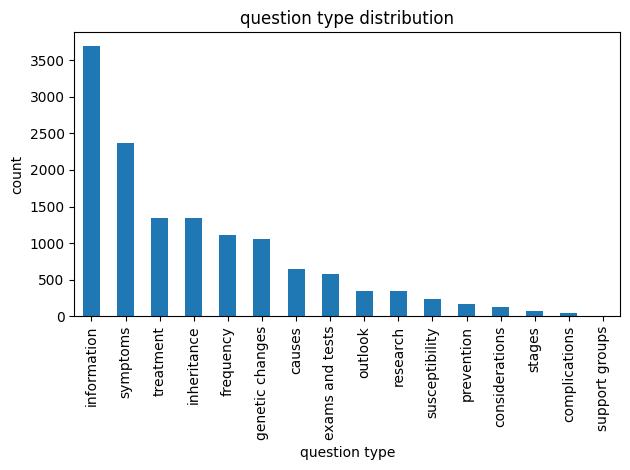

In [ ]:
import matplotlib.pyplot as plt

ax = matched["question_type"].value_counts().plot(kind="bar")
ax.set_xlabel("question type")
ax.set_ylabel("count")
ax.set_title("question type distribution")
plt.tight_layout()
plt.show()


In [ ]:
matched.loc[matched["question_type"] == "support groups"]["answers"].tolist()

['Many people with alcohol problems find it helpful to talk with others who have faced similar problems. Mutual help groups, such as Alcoholics Anonymous (AA) 12-step programs, help people recover from alcohol use disorder. AA meetings are open to anyone who wants to stop drinking. Attending mutual-help groups is beneficial for many people who want to stop drinking. Many people continue to go to support/mutual help groups even after medical treatment for their alcohol problems ends. There are other mutual help groups available such as Smart Recovery, Life Ring, and Moderation Management.  Learn more about available types of treatment for alcohol problems.']

In [ ]:
matched.to_csv("medquad_matched_processed.csv", index=False)

In [ ]:
import pandas as pd

data = pd.read_csv("medquad_matched_processed.csv")
data

,question,answers,prompts,outputs,question_type,question_focus
0,Do you have information about A1C,Summary : A1C is a blood test for type 2 diabe...,<|im_start|>system\nYou are a highly intellige...,1,information,A1C
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1,information,Acupuncture
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1,information,Adoption
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1,information,Advance Directives
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1,information,African American Health
...,...,...,...,...,...,...
13471,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1,research,Problems with Taste
13472,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1,research,Prostate Cancer
13473,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1,research,Psoriasis
13474,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1,research,Skin Cancer


# Train-test-split

In [ ]:
# take a stratified validation split by selecting 20% from each category
val_split_by_category = pd.DataFrame(columns=["question", "answers", "question_type"])
for q_type in data["question_type"].unique().tolist():
    if q_type != "support groups":
        sample = data.loc[data["question_type"] == q_type].sample(frac=0.2, random_state=42)[["question", "answers", "question_type"]]
        val_split_by_category = pd.concat([val_split_by_category, sample])

val_split_by_category



,question,answers,question_type
9413,What is (are) Episodic ataxia ?,Episodic ataxia refers to a group of related c...,information
9042,What is (are) Cat scratch disease ?,Cat scratch disease is an infectious illness c...,information
8687,What is (are) 3-hydroxy-3-methylglutaryl-CoA l...,3-hydroxy-3-methylglutaryl-CoA lyase deficienc...,information
11330,What is (are) hereditary neuropathy with liabi...,Hereditary neuropathy with liability to pressu...,information
9982,What is (are) Limb-girdle muscular dystrophy t...,Limb-girdle muscular dystrophy type 2I (LGMD2I...,information
...,...,...,...
12394,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research
12481,what research (or clinical trials) is being do...,The NINDS supports research on neurological di...,research
12479,what research (or clinical trials) is being do...,The NINDS conducts and supports a wide range o...,research
12499,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research


In [ ]:
val_split_by_category.to_csv("val_split_by_category.csv", index=False)

In [ ]:
# take a train split by excluding the validation selections
train_split = data.loc[~data["question"].isin(val_split_by_category["question"])]
train_split

,question,answers,prompts,outputs,question_type,question_focus
1,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,<|im_start|>system\nYou are a highly intellige...,1,information,Acupuncture
2,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,<|im_start|>system\nYou are a highly intellige...,1,information,Adoption
3,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,<|im_start|>system\nYou are a highly intellige...,1,information,Advance Directives
4,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,<|im_start|>system\nYou are a highly intellige...,1,information,African American Health
5,Do you have information about Air Pollution,Summary : Air pollution is a mixture of solid ...,<|im_start|>system\nYou are a highly intellige...,1,information,Air Pollution
...,...,...,...,...,...,...
13471,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,<|im_start|>system\nYou are a highly intellige...,1,research,Problems with Taste
13472,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,<|im_start|>system\nYou are a highly intellige...,1,research,Prostate Cancer
13473,what research (or clinical trials) is being do...,Scientists who are working to better understan...,<|im_start|>system\nYou are a highly intellige...,1,research,Psoriasis
13474,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,<|im_start|>system\nYou are a highly intellige...,1,research,Skin Cancer


In [ ]:
train_split.to_csv("train_split.csv", index=False)

In [ ]:
import os, wandb
os.environ["WANDB_PROJECT"] = "medquad-sft"
os.environ["WANDB_NAME"]    = "qwen-medquad-lora"
os.environ["WANDB_LOG_MODEL"] = "false"
os.environ["WANDB_WATCH"]     = "false"

wandb.login()

wandb: Currently logged in as: banalyst to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Evaluation (SQuAD EM and f1-score)

In [ ]:
import evaluate
import pandas as pd

val_split_by_category = pd.read_csv("val_split_by_category.csv")

metric = evaluate.load("squad") # uses squad v1

def squad_em_f1(eval: pd.DataFrame):
    # format to feed into evaluate
    preds = [
        {"id": str(i), "prediction_text": (p if isinstance(p, str) else "")}
        for i, p in enumerate(eval["answer_pred"])
    ]

    # take the first answer as gold answer
    refs  = [
        {"id": str(i), "answers": {"text": [g if isinstance(g, str) else ""], "answer_start": [0]}}
        for i, g in enumerate(eval["answer_gold"])
    ]
    return metric.compute(predictions=preds, references=refs)




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
SYSTEM_PROMPT = """You are a medical question answering assistant. Answer the user’s question concisely and accurately."""

def format_input(inp):
    return f"Question: {inp}"

val_split_by_category["prompts"] = val_split_by_category["question"].apply(lambda x: format_input(x))
val_split_by_category


,question,answers,question_type,prompts
0,What is (are) Episodic ataxia ?,Episodic ataxia refers to a group of related c...,information,Question: What is (are) Episodic ataxia ?
1,What is (are) Cat scratch disease ?,Cat scratch disease is an infectious illness c...,information,Question: What is (are) Cat scratch disease ?
2,What is (are) 3-hydroxy-3-methylglutaryl-CoA l...,3-hydroxy-3-methylglutaryl-CoA lyase deficienc...,information,Question: What is (are) 3-hydroxy-3-methylglut...
3,What is (are) hereditary neuropathy with liabi...,Hereditary neuropathy with liability to pressu...,information,Question: What is (are) hereditary neuropathy ...
4,What is (are) Limb-girdle muscular dystrophy t...,Limb-girdle muscular dystrophy type 2I (LGMD2I...,information,Question: What is (are) Limb-girdle muscular d...
...,...,...,...,...
2689,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...
2690,what research (or clinical trials) is being do...,The NINDS supports research on neurological di...,research,Question: what research (or clinical trials) i...
2691,what research (or clinical trials) is being do...,The NINDS conducts and supports a wide range o...,research,Question: what research (or clinical trials) i...
2692,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...


In [ ]:
# model_name = "banalyst/medquad-qwen3-4b-instruct",
# model_name = "/content/lora_model_medquad_v2",

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from unsloth import FastModel
import torch

# load base model again
model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/Qwen3-4B-Instruct-2507",
    max_seq_length = 4096,
    load_in_4bit = True,
    load_in_8bit = False,
    full_finetuning = False,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="flash_attention_2"
)


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.10: Fast Qwen3 patching. Transformers: 4.55.4.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = True]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/132M [00:00<?, ?B/s]

In [ ]:
print(model.generation_config)

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_length": 262144,
  "pad_token_id": 151654,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}



In [ ]:
# enforce eos and pad tokens (caused issues on first iteration)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

eot_id = tokenizer.convert_tokens_to_ids("<|im_end|>")
eos_ids = [tok_id for tok_id in [eot_id, tokenizer.eos_token_id] if tok_id is not None]

model.config.pad_token_id = tokenizer.eos_token_id
model.config.eos_token_id = eos_ids if len(eos_ids) > 1 else eos_ids[0]


In [ ]:
# apply chat template
val_split_by_category["model_inputs"] = val_split_by_category["prompts"].apply(lambda x: apply_template(SYSTEM_PROMPT, x))
val_split_by_category

,question,answers,question_type,prompts,model_inputs
0,What is (are) Episodic ataxia ?,Episodic ataxia refers to a group of related c...,information,Question: What is (are) Episodic ataxia ?,<|im_start|>system\nYou are a medical question...
1,What is (are) Cat scratch disease ?,Cat scratch disease is an infectious illness c...,information,Question: What is (are) Cat scratch disease ?,<|im_start|>system\nYou are a medical question...
2,What is (are) 3-hydroxy-3-methylglutaryl-CoA l...,3-hydroxy-3-methylglutaryl-CoA lyase deficienc...,information,Question: What is (are) 3-hydroxy-3-methylglut...,<|im_start|>system\nYou are a medical question...
3,What is (are) hereditary neuropathy with liabi...,Hereditary neuropathy with liability to pressu...,information,Question: What is (are) hereditary neuropathy ...,<|im_start|>system\nYou are a medical question...
4,What is (are) Limb-girdle muscular dystrophy t...,Limb-girdle muscular dystrophy type 2I (LGMD2I...,information,Question: What is (are) Limb-girdle muscular d...,<|im_start|>system\nYou are a medical question...
...,...,...,...,...,...
2689,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...
2690,what research (or clinical trials) is being do...,The NINDS supports research on neurological di...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...
2691,what research (or clinical trials) is being do...,The NINDS conducts and supports a wide range o...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...
2692,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...


In [ ]:
### eval run for base model ###

dataset = TextDataset(val_split_by_category["model_inputs"].tolist())
dataloader = DataLoader(dataset, batch_size=128, shuffle=False)

from transformers import GenerationConfig

gen_cfg = GenerationConfig(
    max_new_tokens=512,              # QA answers are short
    eos_token_id=model.config.eos_token_id,
    pad_token_id=model.config.pad_token_id,
    temperature=0.7,
    top_p=0.8,
    top_k=20,
    repetition_penalty=1.1,
    no_repeat_ngram_size=4,
    use_cache=True,
)

def generate(dataloader, tokenizer, model):
    inputs = []
    for batch_text in tqdm(dataloader):
        model_inputs = tokenizer.batch_encode_plus(
            batch_text,
            padding="longest",
            padding_side="left",
            truncation=True,
            return_tensors="pt",
        ).to(model.device)
        inputs.append(model_inputs)
    model.eval()
    torch.set_grad_enabled(False)
    for inp in tqdm(inputs):
        with torch.inference_mode():
            yield model.generate(
                **inp,
                generation_config=gen_cfg
            )
out = []
for batch in generate(dataloader, tokenizer, model):
    out.append(batch)

final = []
for output in out:
    decoded = tokenizer.batch_decode(
        output,
        skip_special_tokens=True
    )
    final.extend(decoded)
val_split_by_category["answer_pred"] = final
val_split_by_category

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

`generation_config` default values have been modified to match model-specific defaults: {'max_length': 262144, 'do_sample': True, 'temperature': 0.7, 'top_k': 20, 'top_p': 0.8, 'bos_token_id': 151643}. If this is not desired, please set these values explicitly.


,question,answers,question_type,prompts,model_inputs,answer_pred
0,What is (are) Episodic ataxia ?,Episodic ataxia refers to a group of related c...,information,Question: What is (are) Episodic ataxia ?,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
1,What is (are) Cat scratch disease ?,Cat scratch disease is an infectious illness c...,information,Question: What is (are) Cat scratch disease ?,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
2,What is (are) 3-hydroxy-3-methylglutaryl-CoA l...,3-hydroxy-3-methylglutaryl-CoA lyase deficienc...,information,Question: What is (are) 3-hydroxy-3-methylglut...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
3,What is (are) hereditary neuropathy with liabi...,Hereditary neuropathy with liability to pressu...,information,Question: What is (are) hereditary neuropathy ...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
4,What is (are) Limb-girdle muscular dystrophy t...,Limb-girdle muscular dystrophy type 2I (LGMD2I...,information,Question: What is (are) Limb-girdle muscular d...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
...,...,...,...,...,...,...
2689,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
2690,what research (or clinical trials) is being do...,The NINDS supports research on neurological di...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
2691,what research (or clinical trials) is being do...,The NINDS conducts and supports a wide range o...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...
2692,what research (or clinical trials) is being do...,The mission of the National Institute of Neuro...,research,Question: what research (or clinical trials) i...,<|im_start|>system\nYou are a medical question...,system\nYou are a medical question answering a...


In [ ]:
### Average token counts statistics ###

import numpy as np
train_split = pd.read_csv("train_split.csv")
lens = [len(tokenizer(ans, add_special_tokens=False)["input_ids"]) for ans in train_split["answers"]]
def summarize(arr):
    arr = np.array(arr)
    return {
        "count": len(arr),
        "mean": float(arr.mean()),
        "p50": float(np.percentile(arr, 50)),
        "p75": float(np.percentile(arr, 75)),
        "p90": float(np.percentile(arr, 90)),
        "p95": float(np.percentile(arr, 95)),
        "max": int(arr.max())
    }

# for train split
print("Input token stats:", summarize(lens))

Input token stats: {'count': 10782, 'mean': 284.5247634947134, 'p50': 195.0, 'p75': 347.0, 'p90': 553.0, 'p95': 772.0, 'max': 5704}


In [ ]:
# eval output token count distribution
model_outputs = [ans.split("assistant\n")[1] for ans in final]
lens = [len(tokenizer(ans, add_special_tokens=False)["input_ids"]) for ans in model_outputs]
print("Output token stats:", summarize(lens))

Output token stats: {'count': 2694, 'mean': 288.7958426132146, 'p50': 269.0, 'p75': 379.0, 'p90': 503.7000000000003, 'p95': 512.0, 'max': 514}


In [ ]:
import pandas as pd

### evaluate and compare the baseline and finetuned model performance on eval dataset ###

# val_split_by_category = pd.read_csv("/content/base_instruct_model_eval_outputs.csv")
val_split_by_category = pd.read_csv("/content/finetuned_instruct_model_eval_outputs.csv")
squad_em_f1(val_split_by_category)

{'exact_match': 0.0, 'f1': 30.69809418663648}

In [ ]:
val_split_by_category.to_csv("base_instruct_model_eval_outputs.csv", index=False)

# Training

In [ ]:
# format input for training
train_split["prompts"] = train_split["question"].apply(lambda x: format_input(x))
train_split["prompts"][0]

'Question: Do you have information about Acupuncture'

In [ ]:
# apply train template (key difference is the additional assistant role input in messages, and add_generation_prompt=False)
def apply_train_template(syst
    return tokenizer.apply_chat_template(
        message,
        tokenize=False,
        add_generation_prompt=Fem_prompt, question, answer):
    message = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question},
        {"role": "assistant", "content": answer}
    ]alse,
        enable_thinking=False
    )

inputs = zip(train_split["question"], train_split["answers"])
train_split["model_inputs"] = [apply_train_template(SYSTEM_PROMPT, q, a) for q, a in inputs]
train_split

,question,answers,prompts,outputs,question_type,question_focus,model_inputs
0,Do you have information about Acupuncture,Summary : Acupuncture has been practiced in Ch...,Question: Do you have information about Acupun...,1,information,Acupuncture,<|im_start|>system\nYou are a medical question...
1,Do you have information about Adoption,Summary : Adoption brings a child born to othe...,Question: Do you have information about Adoption,1,information,Adoption,<|im_start|>system\nYou are a medical question...
2,Do you have information about Advance Directives,Summary : What kind of medical care would you ...,Question: Do you have information about Advanc...,1,information,Advance Directives,<|im_start|>system\nYou are a medical question...
3,Do you have information about African American...,Summary : Every racial or ethnic group has spe...,Question: Do you have information about Africa...,1,information,African American Health,<|im_start|>system\nYou are a medical question...
4,Do you have information about Air Pollution,Summary : Air pollution is a mixture of solid ...,Question: Do you have information about Air Po...,1,information,Air Pollution,<|im_start|>system\nYou are a medical question...
...,...,...,...,...,...,...,...
10777,what research (or clinical trials) is being do...,The National Institute on Deafness and Other C...,Question: what research (or clinical trials) i...,1,research,Problems with Taste,<|im_start|>system\nYou are a medical question...
10778,what research (or clinical trials) is being do...,Scientists continue to look at new ways to pre...,Question: what research (or clinical trials) i...,1,research,Prostate Cancer,<|im_start|>system\nYou are a medical question...
10779,what research (or clinical trials) is being do...,Scientists who are working to better understan...,Question: what research (or clinical trials) i...,1,research,Psoriasis,<|im_start|>system\nYou are a medical question...
10780,what research (or clinical trials) is being do...,Many Areas of Research Scientists are constant...,Question: what research (or clinical trials) i...,1,research,Skin Cancer,<|im_start|>system\nYou are a medical question...


In [ ]:
train_split["model_inputs"][0]

"<|im_start|>system\nYou are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>\n<|im_start|>user\nDo you have information about Acupuncture<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\nSummary : Acupuncture has been practiced in China and other Asian countries for thousands of years. Acupuncture involves stimulating specific points on the body. This is most often done by inserting thin needles through the skin, to cause a change in the physical functions of the body.    Research has shown that acupuncture reduces nausea and vomiting after surgery and chemotherapy. It can also relieve pain. Researchers don't fully understand how acupuncture works. It might aid the activity of your body's pain-killing chemicals. It also might affect how you release chemicals that regulate blood pressure and flow.    NIH: National Center for Complementary and Integrative Health<|im_end|>\n"

In [ ]:
# I noticed even though this is a non-thinking model, the <think> tokens are present.
# I remove them just so the training will be slightly more stable.
def replace_think(row):
    row["model_inputs"] = row["model_inputs"].replace("<think>\n\n</think>\n\n", "")
    return row

train_split = train_split.apply(replace_think, axis=1)
train_split["model_inputs"][0]

"<|im_start|>system\nYou are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>\n<|im_start|>user\nDo you have information about Acupuncture<|im_end|>\n<|im_start|>assistant\nSummary : Acupuncture has been practiced in China and other Asian countries for thousands of years. Acupuncture involves stimulating specific points on the body. This is most often done by inserting thin needles through the skin, to cause a change in the physical functions of the body.    Research has shown that acupuncture reduces nausea and vomiting after surgery and chemotherapy. It can also relieve pain. Researchers don't fully understand how acupuncture works. It might aid the activity of your body's pain-killing chemicals. It also might affect how you release chemicals that regulate blood pressure and flow.    NIH: National Center for Complementary and Integrative Health<|im_end|>\n"

In [ ]:
val_split_by_category["model_inputs"][0]

'<|im_start|>system\nYou are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>\n<|im_start|>user\nQuestion: What is (are) Episodic ataxia ?<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_split[["model_inputs"]])
val_ds = Dataset.from_pandas(val_split_by_category[["model_inputs"]])


In [ ]:
### Add QLoRA adapter ###
model = FastModel.get_peft_model(
    model,
    r = 16, # this is enough. 32 was overfitting on first iteration.
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = 32,
    lora_dropout = 0.05, # this was helpful to avoid overfitting
    bias = "none",
    use_gradient_checkpointing = True,
    random_state = 4788,
    use_rslora = False,
    loftq_config = None,
)



Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `model.base_model.model.model` require gradients


In [ ]:
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    do_formatting_func=False,
    args = SFTConfig(
        dataset_text_field = "model_inputs",
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 8,
        warmup_ratio = 0.03,
        num_train_epochs = 2,
        max_seq_length = 1024,
        learning_rate = 5e-5,
        logging_steps = 8,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        eval_strategy="steps",
        eval_steps=32,
        save_strategy="steps",
        save_steps=32,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        seed = 3407,
        bf16=True,
        report_to="wandb",
        run_name=os.environ.get("WANDB_NAME", "run"),
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)],
)

Unsloth: Tokenizing ["model_inputs"] (num_proc=16):   0%|          | 0/10782 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["model_inputs"] (num_proc=16):   0%|          | 0/2694 [00:00<?, ? examples/s]

In [ ]:
from unsloth.chat_templates import train_on_responses_only
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<|im_start|>user\n",
    response_part = "<|im_start|>assistant\n",
)

Map (num_proc=12):   0%|          | 0/10782 [00:00<?, ? examples/s]

Map (num_proc=12):   0%|          | 0/2694 [00:00<?, ? examples/s]

In [ ]:
tokenizer.decode(trainer.train_dataset[100]["input_ids"])

"<|im_start|>system\nYou are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>\n<|im_start|>user\nDo you have information about Hazardous Waste<|im_end|>\n<|im_start|>assistant\nSummary : Even if you use them properly, many chemicals can still harm human health and the environment. When you throw these substances away, they become hazardous waste. Some hazardous wastes come from products in our homes. Our garbage can include such hazardous wastes as old batteries, bug spray cans and paint thinner. U.S. residents generate 1.6 million tons of household hazardous waste per year. Hazardous waste is also a by-product of manufacturing.     You may have hazardous wastes in your basement or garage. How do you get rid of them? Don't pour them down the drain, flush them, or put them in the garbage. See if you can donate or recycle. Many communities have household hazardous waste collection programs. Check to see if there is one in your area.  

In [ ]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[100]["labels"]]).replace(tokenizer.pad_token, " ")

"                                        Summary : Even if you use them properly, many chemicals can still harm human health and the environment. When you throw these substances away, they become hazardous waste. Some hazardous wastes come from products in our homes. Our garbage can include such hazardous wastes as old batteries, bug spray cans and paint thinner. U.S. residents generate 1.6 million tons of household hazardous waste per year. Hazardous waste is also a by-product of manufacturing.     You may have hazardous wastes in your basement or garage. How do you get rid of them? Don't pour them down the drain, flush them, or put them in the garbage. See if you can donate or recycle. Many communities have household hazardous waste collection programs. Check to see if there is one in your area.    Environmental Protection Agency<|im_end|>\n"

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 10,782 | Num Epochs = 2 | Total steps = 86
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 8 x 1) = 256
 "-____-"     Trainable parameters = 33,030,144 of 4,055,498,240 (0.81% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,entropy
32,1.298100,nan,0
64,1.167500,nan,No Log


Unsloth: Not an error, but Qwen3ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


In [ ]:
model.save_pretrained("lora_model_medquad_v2")

In [ ]:
tokenizer.save_pretrained("lora_model_medquad_v2")

('lora_model_medquad_v2/tokenizer_config.json',
 'lora_model_medquad_v2/special_tokens_map.json',
 'lora_model_medquad_v2/chat_template.jinja',
 'lora_model_medquad_v2/vocab.json',
 'lora_model_medquad_v2/merges.txt',
 'lora_model_medquad_v2/added_tokens.json',
 'lora_model_medquad_v2/tokenizer.json')

In [ ]:
from huggingface_hub import HfApi

api = HfApi(token="<|API KEY|>")
api.upload_folder(
    folder_path="/content/lora_model_medquad_v2",
    repo_id="banalyst/medquad-qwen3-4b-instruct",
    repo_type="model",
)


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/banalyst/medquad-qwen3-4b-instruct/commit/1418353ad1285b374ab37b5527ef55507f08127f', commit_message='Upload folder using huggingface_hub', commit_description='', oid='1418353ad1285b374ab37b5527ef55507f08127f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/banalyst/medquad-qwen3-4b-instruct', endpoint='https://huggingface.co', repo_type='model', repo_id='banalyst/medquad-qwen3-4b-instruct'), pr_revision=None, pr_num=None)

# Example Interactions

In [ ]:
SYSTEM_PROMPT = """You are a medical question answering assistant. Answer the user’s question concisely and accurately."""

three_examples = [
    "Question: What is a cyst?",
    "Question: What are the differences between the stages of breast cancer?",
    "Question: How to treat an infection?"
]

def generate(system_prompt, user_prompts):
    outs = []
    for user_prompt in user_prompts:
        messages = [
            {"role" : "system", "content" : system_prompt},
            {"role" : "user", "content" : user_prompt}
        ]
        text = tokenizer.apply_chat_template(
            messages,
            tokenize = False,
            add_generation_prompt = True,
        )
        print(text)
        inputs = tokenizer(
            text,
            padding=True,
            padding_side="left",
            truncation=True,
            return_tensors = "pt"
        ).to("cuda")

        out = model.generate(
            **inputs,
            max_new_tokens = 512,
            temperature = 0.7,
            top_p = 0.8,
            top_k = 20,
            repetition_penalty=1.1,
            no_repeat_ngram_size=4,
            use_cache=False,
        )
        outs.append(tokenizer.decode(out[0], skip_special_tokens = True))
    return outs

outs = generate(SYSTEM_PROMPT, three_examples)
outs

<|im_start|>system
You are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>
<|im_start|>user
Question: What is a cyst?<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>
<|im_start|>user
Question: What are the differences between the stages of breast cancer?<|im_end|>
<|im_start|>assistant

<|im_start|>system
You are a medical question answering assistant. Answer the user’s question concisely and accurately.<|im_end|>
<|im_start|>user
Question: How to treat an infection?<|im_end|>
<|im_start|>assistant



["system\nYou are a medical question answering assistant. Answer the user’s question concisely and accurately.\nuser\nQuestion: What is a cyst?\nassistant\nA cyst is an abnormal sac or cavity that forms in the skin, glands, or internal organs. Cysts may contain fluid, air, pus, hair, fat, or other materials. Some cysts have no symptoms; others cause pain or swelling. Most cysts do not require treatment. A doctor may drain or remove a cyst if it becomes large or painful.  Cystic acne is a type of acne that occurs when a clogged pore fills with oil (sebum), dead skin cells, bacteria, and debris. This material causes inflammation, forming a pimple or bump under the surface of the skin. Sometimes, this inflamed area fills with fluid to form a cyst. Cystic nodules and cystic acne are more common among people who have severe acne. The exact cause of cystic acne is unknown. It is likely caused by hormonal changes during puberty. Cystinosis is a rare condition that affects how your body breaks